# Monkeybread Tutorial

This tutorial will walk through the different tools Monkeybread provides, what they do, and how to use them. Monkeybread’s tools focus on cellular organization in spatial transcriptomics data, with a focus on exploring how different cell types colocalize forming distinct cellular niches in the tissue microenvironment.


## Import packages

Before getting started, we will import a few packages.

In [1]:
import sys
import subprocess
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from anndata import AnnData
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

import monkeybread as mb 

## Load and preprocess data

We will look a human melanoma tumor dataset published by Vizgen. The raw data can be accessed from their website or downloaded directly from their Google bucket. Here we will download the data from their Google bucket. This will require that you have [gsutil](https://cloud.google.com/storage/docs/gsutil) installed on your system.

Specifically, this data has already been processed by Vizgen's image processing pipeline. This pipeline entailed segmenting the cells and assigning each detected transcript to a cell. This formed a cell-by-gene counts matrix. The `cell_by_gene.csv` file stores stores this count matrix where the rows represent cells and genes as columns. The `cell_metadata.csv` contains additional information for each cells such as their x-y spatial coordinates and the sizes of the bounding boxes containing the boundaries of each cell. Lastly, the `detected_transcripts.csv` file stores information on each individual transcript. For now, we will not be looking at this file.

First, let's download the data using `gsutil`:

In [2]:
# Use gsutil to download the data from Google Cloud where the public data is stored
subprocess.run(
    "mkdir HumanMelanomaPatient2",
    shell = True
)
subprocess.run(
    "gsutil -m cp -n gs://vz-ffpe-showcase/HumanMelanomaPatient2/cell_by_gene.csv \
    gs://vz-ffpe-showcase/HumanMelanomaPatient2/cell_metadata.csv \
    ./HumanMelanomaPatient2/",
    shell = True
)

mkdir: cannot create directory ‘HumanMelanomaPatient2’: File exists
Skipping existing item: file://./HumanMelanomaPatient2/cell_metadata.csv
Skipping existing item: file://./HumanMelanomaPatient2/cell_by_gene.csv


CompletedProcess(args='gsutil -m cp -n gs://vz-ffpe-showcase/HumanMelanomaPatient2/cell_by_gene.csv     gs://vz-ffpe-showcase/HumanMelanomaPatient2/cell_metadata.csv     ./HumanMelanomaPatient2/', returncode=0)

We will use a utility function to load this data into an `AnnData` object:

In [3]:
adata = mb.util.load_merscope("./HumanMelanomaPatient2")

For this tutorial tutorial, we will use a provided annotation available at Monkeybread's GitHub repository. We will download this data and add the annotation to the AnnData object:

In [4]:
# Download the file
subprocess.run('curl -OL https://github.com/immunitastx/monkeybread/raw/main/example_data/HumanMelanomaPatient2_annotation.tsv', shell=True)

# Load the file
annot_df = pd.read_csv('./HumanMelanomaPatient2_annotation.tsv', index_col=0, sep='\t')
annot_df.index = [str(x) for x in annot_df.index]

# Add to Anndata object. Note, these annotations are provided for a filtered 
# set of cells (cells with less than 10 transcripts are not annotated and will be filterd)
adata = adata[annot_df.index]
adata.obs['Cell Type'] = pd.Categorical(
    list(annot_df['Cell Type']), 
    categories=[
        'B lineage',
        'CD4 T',
        'CD8 T',
        'Treg',
        'NK',
        'pDC',
        'cDC',
        'mregDC',
        'mono/mac',
        'granulocyte',
        'stromal',
        'malignant',
        'endothelial',
        'other'
    ], 
    ordered=True
)
adata.obs['Cell Subtype'] = list(annot_df['Cell Subtype'])

# Display the `obs` dataframe
adata.obs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4877k  100 4877k    0     0  4614k      0  0:00:01  0:00:01 --:--:--  155M
/tmp/ipykernel_2767/2973977461.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Cell Type'] = pd.Categorical(


width     height   fov    Cell Type           Cell Subtype
183932  19.050605  18.497379     0  endothelial            endothelial
183936  10.547030  12.585172     0  endothelial            endothelial
183938   5.716220   4.903717     0      stromal                stromal
183939  14.804707  14.309373     0  endothelial            endothelial
183942   9.185763  19.802523     0  endothelial            endothelial
...           ...        ...   ...          ...                    ...
34217    9.784461   3.276215  1180        other                  other
34218    9.095214  11.359051  1180  endothelial            endothelial
34219    5.500457   6.956891  1180  endothelial            endothelial
34221    7.114672  11.638629  1180     mono/mac  mono/mac (CD163-high)
34225    5.268841   5.443394  1180  endothelial            endothelial

[189071 rows x 5 columns]

### Normalize the counts

In [5]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)

### Visualize marker gene expression in each cell types

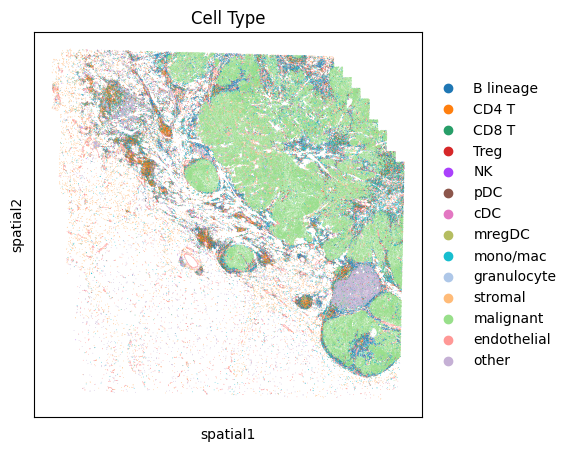

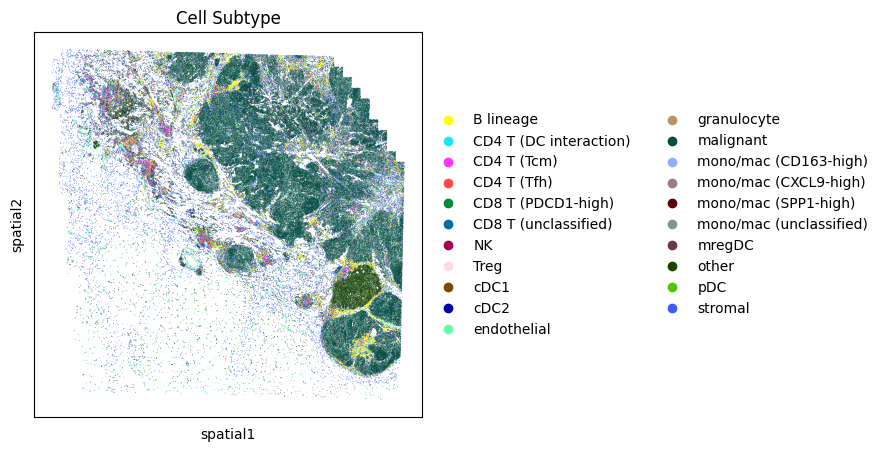

categories: B lineage, CD4 T (DC interaction), CD4 T (Tcm), etc.
var_group_labels: T cell, CD8 T, CD4 T, etc.


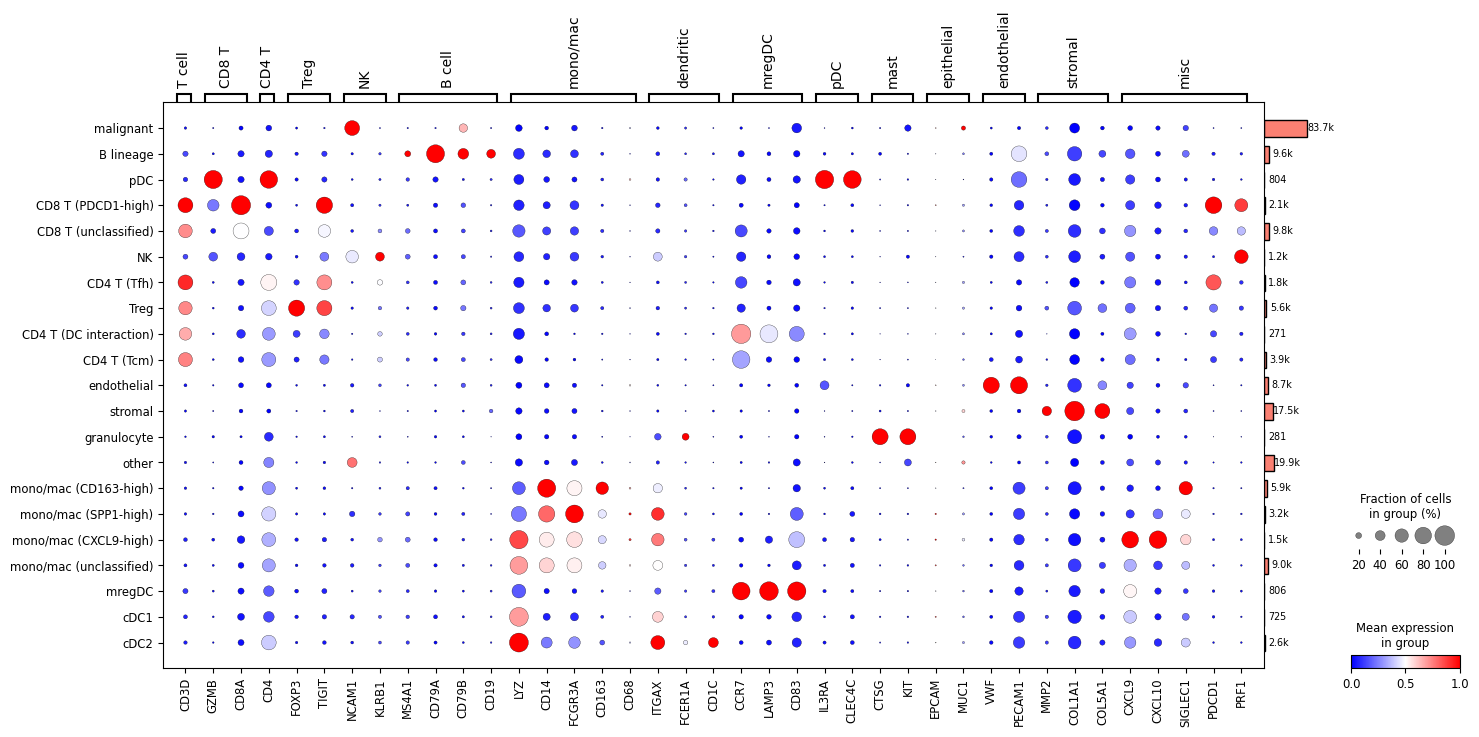

In [6]:
# Display high-level cell types
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sc.pl.embedding(
    adata,
    "spatial",
    color = 'Cell Type',
    s=1,
    ax=ax,
    palette=sc.pl.palettes.vega_20_scanpy,
    show=False
)
plt.show()


# Display more granular cell subtypes
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sc.pl.embedding(
    adata,
    "spatial",
    color = 'Cell Subtype',
    s=1,
    ax=ax,
    palette=sc.pl.palettes.godsnot_102,
    show=False
)
plt.show()

# Display expression dotplot
sc.tl.dendrogram(adata, groupby='Cell Subtype')
dp = sc.pl.dotplot(
    adata, 
    var_names={
        'T cell': [
            'CD3D'
        ],
        'CD8 T': [
            'GZMB',
            'CD8A'
        ],
        'CD4 T': [
            'CD4'
        ],
        'Treg': [
            'FOXP3', 
            'TIGIT'
        ],
        'NK': [
            'NCAM1', 
            'KLRB1'
        ],
        'B cell': [
            'MS4A1',
            'CD79A',
            'CD79B',
            'CD19'
        ],
        'mono/mac': [
            'LYZ', 
            'CD14', 
            'FCGR3A', 
            'CD163',
            'CD68'
        ],
        'dendritic': [
            'ITGAX',
            'FCER1A',
            'CD1C'
        ],
        'mregDC': [
            'CCR7',
            'LAMP3',
            'CD83'
        ],
        'pDC': [
            'IL3RA',
            'CLEC4C'
        ],
        'mast': [
            'CTSG',
            'KIT'
        ],
        'epithelial': [
            'EPCAM',
            'MUC1'
        ],
        'endothelial': [
            'VWF', 
            'PECAM1'
        ],
        'stromal': [
            'MMP2',
            'COL1A1',
            'COL5A1'
        ],
        'misc': [
            'CXCL9',
            'CXCL10',
            'SIGLEC1',
            'PDCD1',
            'PRF1'
        ]
    },
    groupby=['Cell Subtype'],
    standard_scale='var',
    cmap='bwr',
    dendrogram=True,
    return_fig=True
)
dp.add_totals().show()



## Zoom-in and subset the data

We first describe Monkeybread's function for zooming-in to a region of the tissue and subsetting the data. To do so, we use the `mb.plot.embedding_zoom`. This function takes as an argument the AnnData oject as well as the coordinates of a rectangle used to bound the zoomed-in region. These coordinates are as follows:

* `left_pct`: Distance from the left-side of the tissue in units of percentage of the width of the tissue. In this example, we grab a rectangle whose top-left corner starts at 75% from the left side of the tissue.
* `top_pct`: Distance from the left-side of the tissue in units of percentage of the height of the tissue. In this example, we grab a rectangle whose top-left corner starts at 54% from the top of the tissue.
* `width_pct`: Width of the bounding box in units of percentage of the width of the tissue. In this example, we grab a rectangle whose width is 15% of the width of the tissue
* `height_pct`: Height of the bounding box in units of percentage of the height of the tissue. In this example, we grab a rectangle whose height is 15% of the height of the tissue

This function will return an AnnData object storing all of cells in the zoomed-in region.

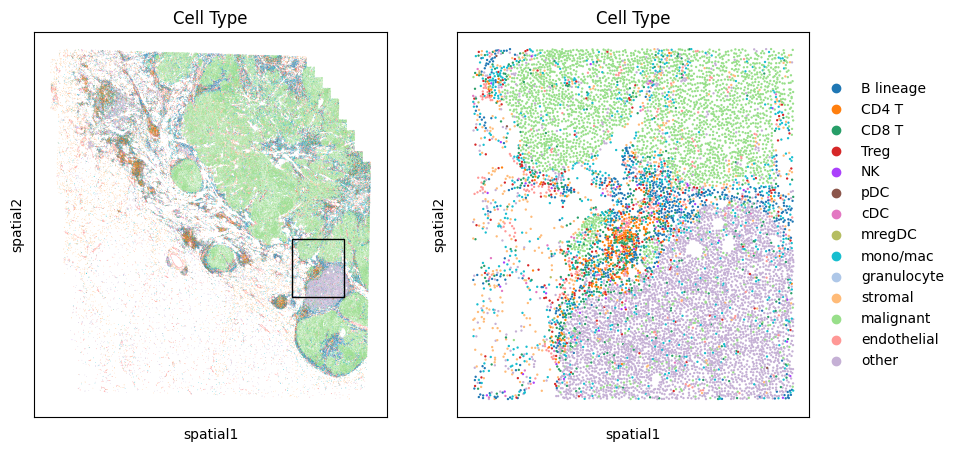

In [7]:
# Coordinates of bounding box of zoomed-in region
LEFT_PCT = 73
TOP_PCT = 54
WIDTH_PCT = 15
HEIGHT_PCT = 15

fig, axarr = plt.subplots(1,2,figsize=(10,5))
adata_zoom = mb.plot.embedding_zoom(
    adata, 
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT, 
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    color='Cell Type', 
    mask=None, 
    basis='spatial', 
    palette=sc.pl.palettes.vega_20_scanpy,
    show=True,
    axs=axarr
);


## Plot density of cells of a given cell type

Next, we demonstrate how to use kernel density estimation to visualize the density of cells of a given cell type. Below, we plot the density of B cells in the zoomed-in region.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10537/10537 [00:30<00:00, 340.74it/s]


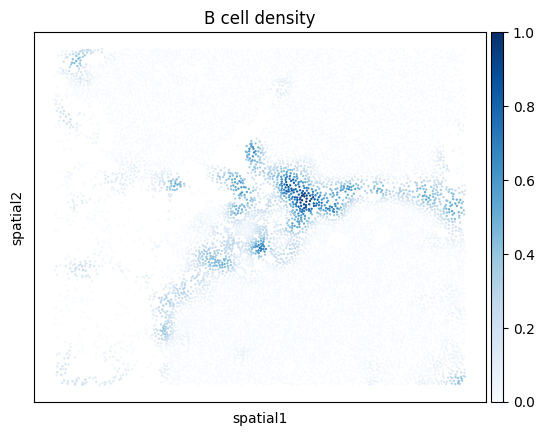

In [8]:
density_key = mb.calc.cell_density(
    adata_zoom,
    'Cell Type',
    'B lineage',
    bandwidth=25,
    approx=False,
    radius_threshold=250
)
mb.plot.cell_density(
    adata_zoom,
    density_key,
    cmap='Blues',
    title=f'B cell density'
)


Note that computing the kernel density estimate for the full tissue can a long time and consume a lot of memory with this many cells. To facilitate visualization on large datasets, Monkeybread provides an approximation to the kernel density estimation that aggregates cells using a grid. This approximation can be run by setting `approx` to True. The resolution controls the granularity of the grid as shown below:

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


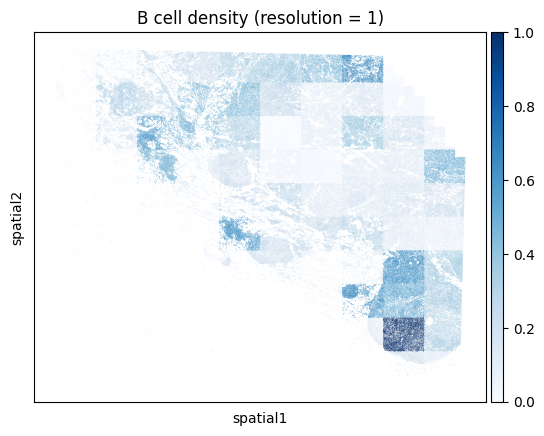

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


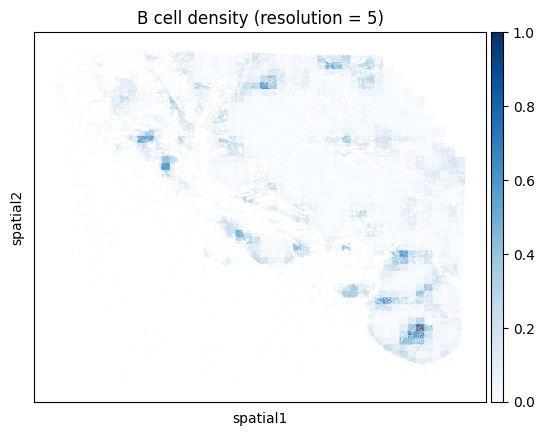

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


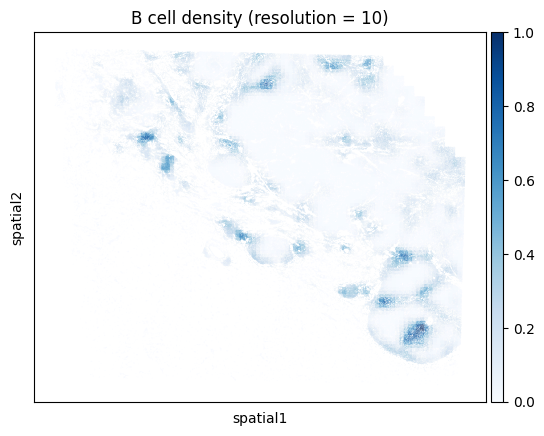

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


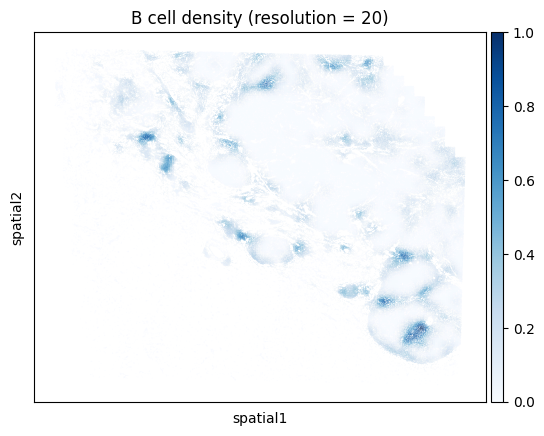

In [9]:
# Iterate through resolution parameters
for res in [1, 5, 10, 20]:
    density_key = mb.calc.cell_density(
        adata,
        'Cell Type',
        'B lineage',
        bandwidth=50,
        resolution=res
    )
    mb.plot.cell_density(
        adata,
        density_key,
        cmap='Blues',
        title=f'B cell density (resolution = {res})'
    )

One can also compute the density for a union of cell types. For example, below we compute the density of _all_ T cells regardless of subtype. We do so by passing a list of cell types that we want to group together. Here we look at the union of all conventional CD4 T cells, CD8 T cells, and Tregs.

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


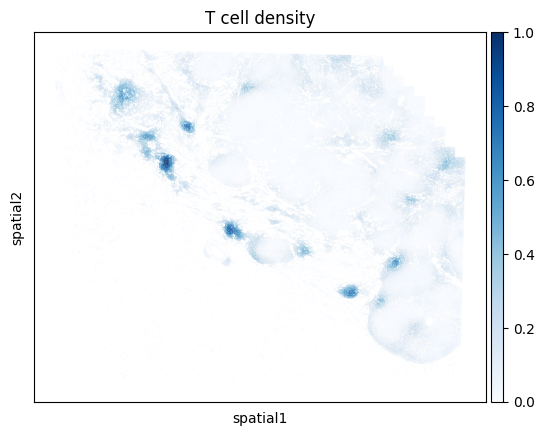

In [10]:
density_key = mb.calc.cell_density(
    adata,
    'Cell Type',
    ['CD4 T', 'CD8 T', 'Treg'], # Union of all T cell types
    bandwidth=50,
    resolution=20
)
mb.plot.cell_density(
    adata,
    density_key,
    cmap='Blues',
    title=f'T cell density'
)

### Location with density plots

The `location_and_density` function is a wrapper function around `sc.pl.embedding` and `mb.plot.kernel_density`. It outputs a multi-panel figure where the left-most plot is an embedding plot showing the locations of cells that are of a given set of cell types. The other plots are spatial density plots for each cell type.

In the example below we show the distribution of B cells and CD4 Tfh cells.

/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))
/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))


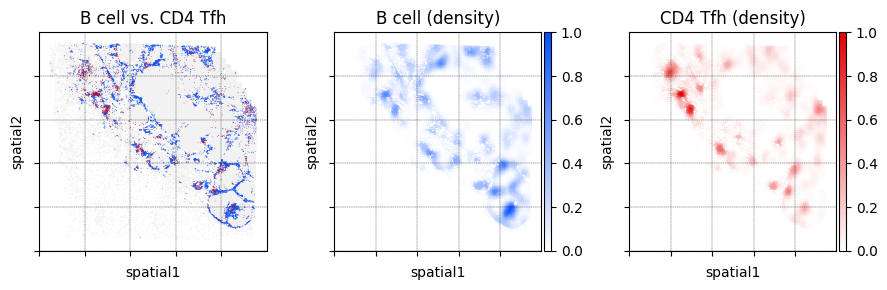

In [11]:
fig, _ = mb.plot.location_and_density(
    adata, 
    'Cell Subtype',                   
    [
        ['B lineage'],  # The first group of cell types to plot
        ['CD4 T (Tfh)'] # The second group of cell types to plot
    ],      
    [
        'B cell', # Name of the first group of cell types
        'CD4 Tfh' # Name of the second group of cell types
    ],
    dot_size=[1, 1], # Dot sizes for each group
    title='B cell vs. CD4 Tfh', 
    grid=True, 
    n_grids=5,
    show=False
)
plt.tight_layout()
plt.show()

We can display more than just two cell types. Below we also plot the locations of dendritic cells

/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/calc/_cell_density.py:117: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(bin_distances / bandwidth))
/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../m

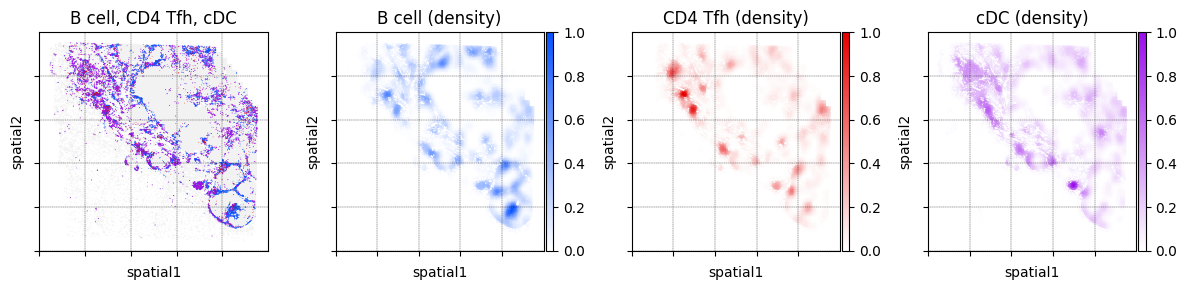

In [12]:
fig, _ = mb.plot.location_and_density(
    adata, 
    'Cell Subtype',                   
    [
        ['B lineage'],  # The first group of cell types to plot
        ['CD4 T (Tfh)'], # The second group of cell types to plot
        ['cDC1', 'cDC2', 'mregDC'], # The third group of cell types to plot
    ],      
    [
        'B cell', # Name of the first group of cell types
        'CD4 Tfh', # Name of the second group of cell types
        'cDC', # Name of the third group of cell types to plot
    ],
    dot_size=[1, 1, 2], 
    title='B cell, CD4 Tfh, cDC', 
    grid=True, 
    n_grids=5,
    show=False
)
plt.tight_layout()
plt.show()

# Niche analysis

We now demonstrate how to perform an analysis of cellular niches. Specifically, for each cell, we count the number of neighbors that are of each cell type thus forming a "neighborhood profile" vector of length C, where C is the number of cell types. We then cluster all neighborhood profiles and call each cluster a "niche".

We start by defining the cell types that we will consider for our niche analysis. We will group the unclassified cells labeled as "other" together with "malignant cells" and form a new column in `adata.obs` for the re-names cell subtypes:

In [13]:
niche_subtypes = []
other_cell_types = ['other', 'malignant']
for cell, ct in zip(adata.obs.index, adata.obs['Cell Subtype']):
    if ct in other_cell_types:
        niche_subtypes.append('malignant/other')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = niche_subtypes
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))

Cell subtypes considered in niche analysis:
{'NK', 'CD8 T (unclassified)', 'endothelial', 'Treg', 'mono/mac (unclassified)', 'cDC2', 'CD4 T (Tcm)', 'granulocyte', 'B lineage', 'mregDC', 'mono/mac (CD163-high)', 'mono/mac (SPP1-high)', 'malignant/other', 'CD4 T (DC interaction)', 'CD4 T (Tfh)', 'stromal', 'cDC1', 'pDC', 'CD8 T (PDCD1-high)', 'mono/mac (CXCL9-high)'}


Next, we generate cellular niches. This algorithm works by first computing the neighborhood profile of each cell using the function `mb.calc.neighborhood` profile. This function will return a new `AnnData` object that stores a cells-by-celltype matrix. We normalize these neighborhood profile as follows:
* By setting `normalize_counts = True`, we normalize each neighbor count by the total number of neighbors in each cell's vicinity
* By setting `standard_scale = True`, we compute the z-score of these neighborhood profiles by subtracting the mean and dividing by standard deviation

These neighborhood profiles are then clustered via `sc.pp.neighbors` and `sc.tl.leiden`. The parameters `n_neighbors` and `resolution` are provided two these two functions respectively.

All clusters that are greater than `min_niche_size` are used to define the niche of each cell. All cells within clusters that are less than this value or are not immune cells are assigned to the "catch all" niche provided by the `non_niche_value` argument.

In [14]:
# Only perform niche analysis on immune cells
immune_mask = ~adata.obs['niche_subtypes'].isin([
    'malignant/other', 'endothelial', 'stromal'
])

# Compute niches
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    mask=immune_mask,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other'
)

Computing neighborhood profiles...
Clustering neighborhood profiles...


/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disks/scratch/mbernstein/miniconda3/p

Generating niches...


Below we visualize the distribution of neighborhood profile values for a subset of the cell types. Notice that despite how some cell types are more common than others, the neighborhood profile values are on a similar scale. This is due to the previously described normalization procedure.

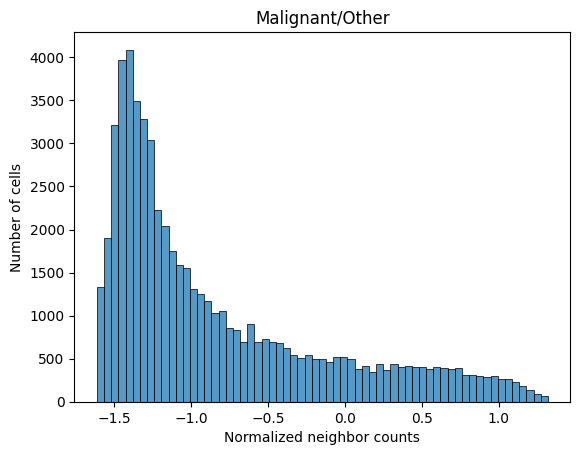

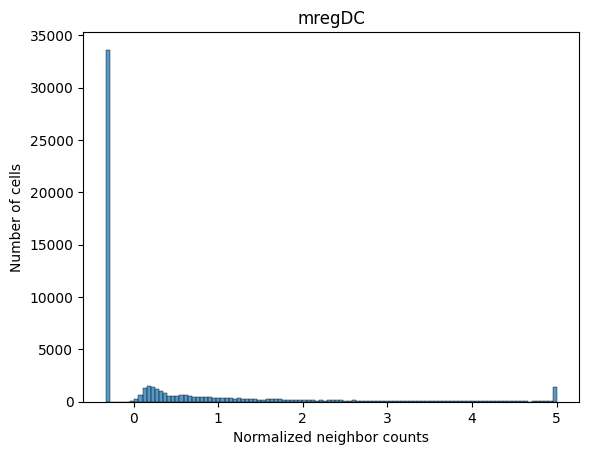

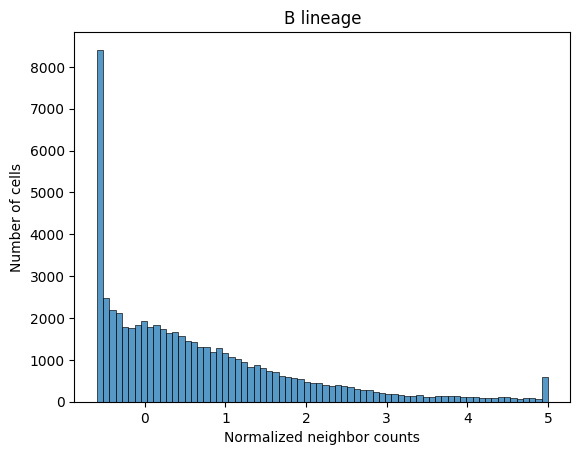

In [15]:
sns.histplot(adata_neighbors.obs_vector('malignant/other'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('Malignant/Other')
plt.show()

sns.histplot(adata_neighbors.obs_vector('mregDC'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('mregDC')
plt.show()

sns.histplot(adata_neighbors.obs_vector('B lineage'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('B lineage')
plt.show()

Visualize the neighborhood profiles using UMAP. These UMAP values were calculated by the `mb.calc.cellular_niches` function.  To speed-up computation, we subsample the cells by half just for visualization purposes.

We notice that cells do not necessarily cluster by cell type. Rather, they cluster by how similar their neighborhood compositions are.

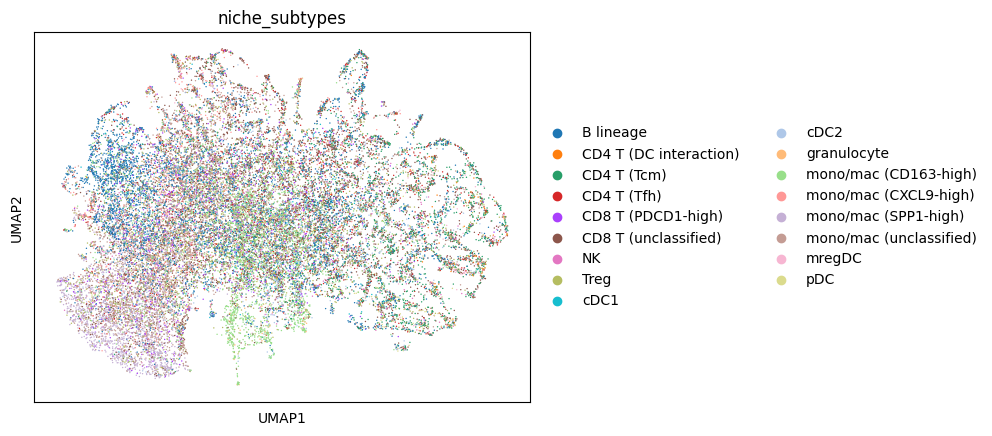

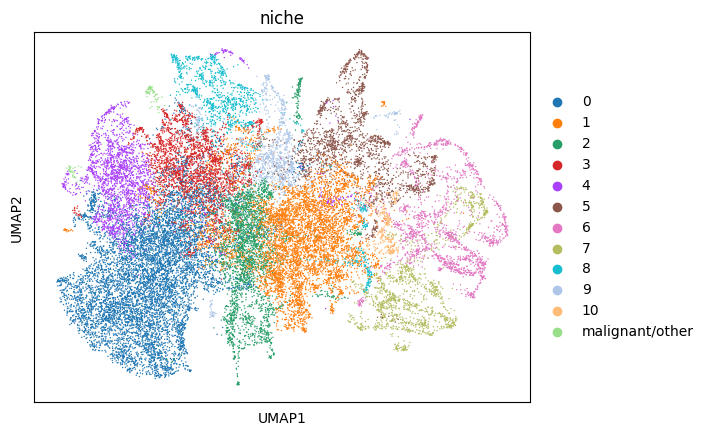

In [16]:
# Subset cells
adata_neighbors_sub = sc.pp.subsample(
    adata_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy
)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy
)

Plot the tissue colored by niches

<AxesSubplot:title={'center':'niche'}, xlabel='spatial1', ylabel='spatial2'>

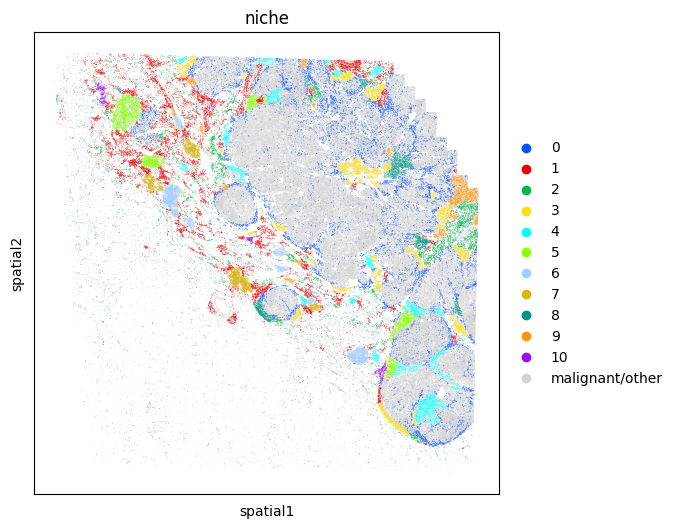

In [17]:
# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors.obs['niche'])))
}
niche_to_color['malignant/other'] = 'lightgrey'

fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.embedding(
    adata,
    "spatial",
    color = 'niche',
    palette=niche_to_color,
    s=1,
    ax=ax,
    show=False
)

Next we will plot the enrichment of cell types in each niche using monkeybread's `neighbors_profile_matrixplot` plot. This plot shows the average value of the normalized neighbor counts across all cells in each niche. 

Notice, because the neighborhood counts were normalized and transformed via the Z-score, a value of zero for a given cell type indicates that the normalized number of neighbors equals the mean number of neighbors. A value of 1 indicates that the normalized number of neighbors is one standard deviation above the mean.

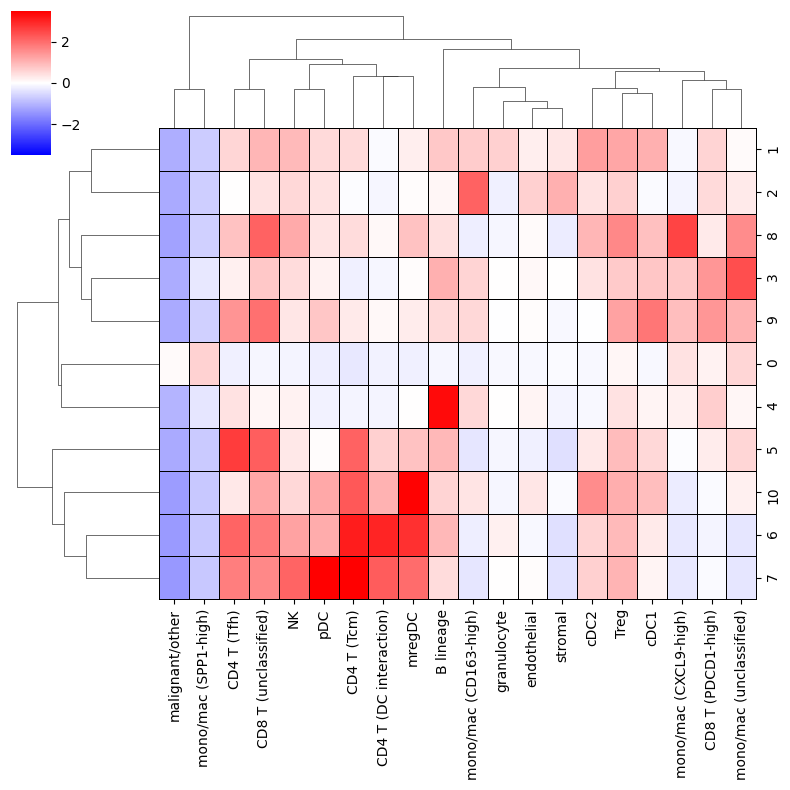

In [18]:
mb.plot.neighbors_profile_matrixplot(
    adata_neighbors,
    'niche',
    include_niches=[ # Exclude the miscellaneous niches from the plot
        niche 
        for niche in set(adata_neighbors.obs['niche'])
        if niche != 'malignant/other'
    ],
    clustermap_kwargs={
        'linewidths': 0.5,
        'linecolor': 'black',
        'cmap': 'bwr',
        'clip_on': False,
        'vmin': -3.5,
        'vmax': 3.5,
        'figsize': (8,8)
    }
)

# Comparing gene expression between niches

Next we'll show how the niche annotation can be further explored by examining changes in gene expression between these niches

## Visualizing gene expression differences

Below we zoom on a specific region of the specimen and color each cell by their expression of CXCL9 and CXCL10, two genes that are up-regulated in response to interferon.

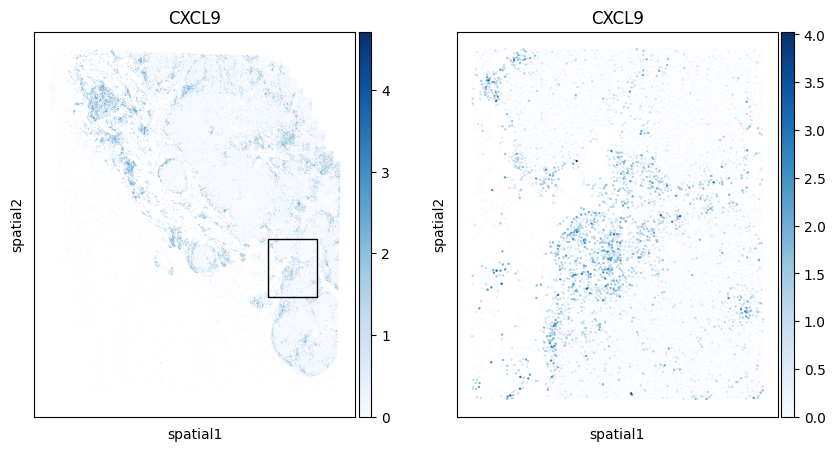

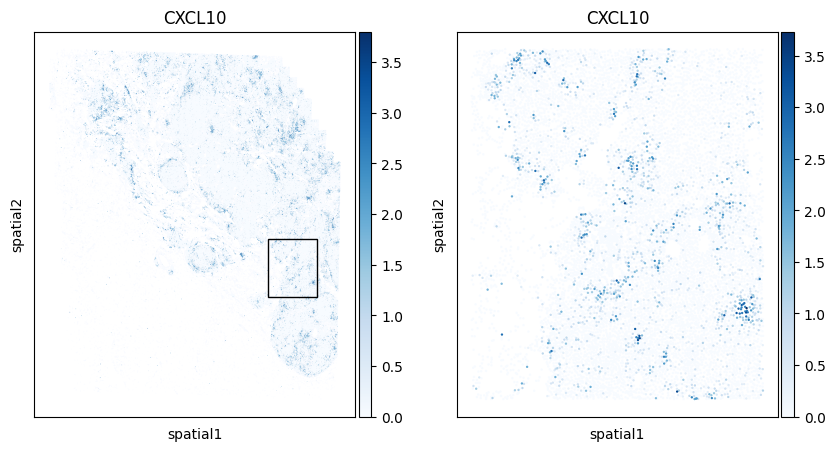

In [19]:
# Coordinates of bounding box of zoomed-in region
LEFT_PCT = 73
TOP_PCT = 54
WIDTH_PCT = 15
HEIGHT_PCT = 15

fig, axarr = plt.subplots(1,2,figsize=(10,5))
mb.plot.embedding_zoom(
    adata, 
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT, 
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    color='CXCL9', 
    mask=None, 
    basis='spatial',
    cmap='Blues',
    use_raw=False,
    show=True,
    axs=axarr
);

fig, axarr = plt.subplots(1,2,figsize=(10,5))
mb.plot.embedding_zoom(
    adata, 
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT, 
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    color='CXCL10',
    use_raw=False,
    mask=None, 
    basis='spatial',
    cmap='Blues',
    show=True,
    axs=axarr
);

We'll use Scanpy's native violin plot function to explore the expression of CXCL9 and CXCL10 in all cells within Niches 2 and 5

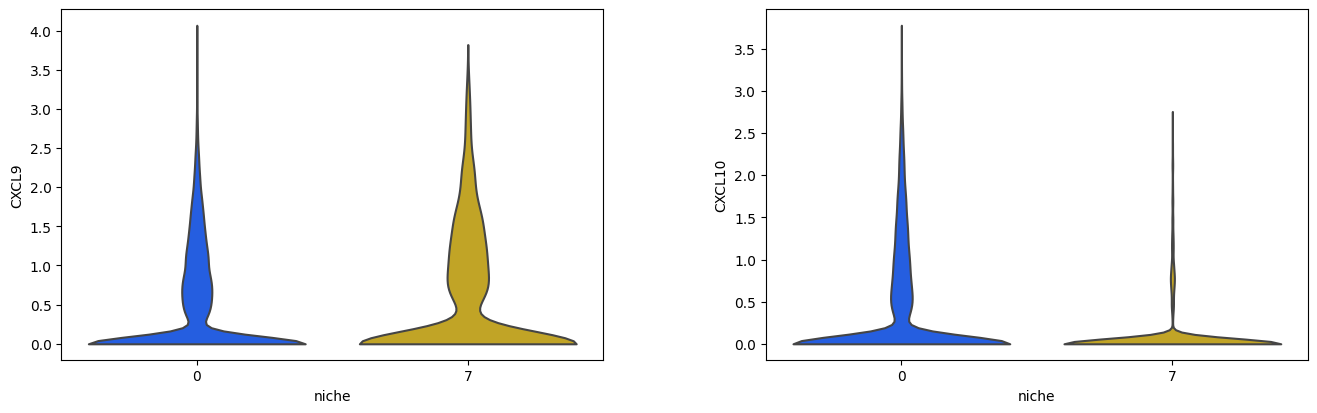

In [20]:
sc.pl.violin(
    adata[adata.obs['niche'].isin(['0', '7'])], 
    groupby='niche', 
    keys=['CXCL9', 'CXCL10'], 
    palette=[
        niche_to_color['0'],
        niche_to_color['7']
    ],
    use_raw=False,
    stripplot=False
)

## Differential expression analysis between cells in different niches

Here we demonstrate how to use Scanpy to perform differential expression analysis between cells in different niches. Specifically, we will perform a DE analysis between T cells in Niches 4 and 2. We begin by isolating the T cells in these niches.

In [21]:
adata_t = adata[adata.obs['Cell Type'].isin(['CD4 T', 'CD8 T', 'Treg'])]
adata_t = adata_t[adata_t.obs['niche'].isin(['0', '7'])]

Use Scanpy to perform differential expression

In [22]:
sc.tl.rank_genes_groups(adata_t, groupby='niche')

/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


Extract top DE genes from the T cells in each niche

In [23]:
df_de = sc.get.rank_genes_groups_df(adata_t, group='0')
df_de = df_de.loc[(df_de['logfoldchanges'] > 0) & (df_de['pvals_adj'] < 0.05)]
top_de_4 = list(df_de['names'])

print(f'Total of {len(top_de_4)} DE genes higher Cluster 0:')
print(', '.join(top_de_4))
print()

df_de = sc.get.rank_genes_groups_df(adata_t, group='7')
df_de = df_de.loc[(df_de['logfoldchanges'] > 0) & (df_de['pvals_adj'] < 0.05)]
top_de_2 = list(df_de['names'])
print(f'Total of {len(top_de_2)} DE genes higher Cluster 7:')
print(', '.join(top_de_2))

Total of 414 DE genes higher Cluster 0:
PKM, FN1, LMNA, FCGR3A, CTNNB1, CCND1, HAVCR2, LAG3, BST2, CSF1, WWTR1, HLA-DRA, CDK2, SOD2, JUN, CEBPB, CCR1, GZMH, CXCR6, C1QC, TNFRSF9, CDK6, CD276, IL2RB, AKT1, SNAI2, LRP1, ZBED2, HLA-DRB1, NKG7, YAP1, TEAD1, BCL2L1, SERPINA1, SOX9, COL1A1, CCR5, LDHA, COL5A1, IDH1, HIF1A, CXCL10, CTLA4, SPRY2, FOS, PDCD1, CD8A, ERBB3, CAV1, BMP1, CCL3, LYZ, CDK4, NRAS, FCGR2A, TREM2, NOTCH1, CD14, ICAM1, CYBB, TNFRSF18, TMEM37, MMP1, TGFBI, MAFB, SPP1, ITGB1, TNC, IFNGR2, NFE2L2, TEAD4, PRF1, FASLG, HLA-DMA, TIGIT, PDK4, HLA-C, CCL5, VEGFB, GZMB, BIRC5, FOXP3, NCAM1, PDGFA, IL4I1, TBK1, MSR1, TNFRSF4, TAP1, PTK2, STAT3, FOXM1, SRC, CD248, MCM6, MARCO, PCNA, CD2, ASCL2, ERBB2, GZMA, EZH2, HLA-B, KIR2DL4, PDGFRA, AMOTL2, LGALS9, TBX21, IL12RB2, TLR2, MYBL2, BAX, IFNG, S100A9, ICOS, ITGAM, CSF1R, MMP2, TBX3, ATF3, CDKN1A, CCL4, BRCA1, PDGFC, CD244, CDH1, MCM2, SHARPIN, MMRN1, HLA-DPB1, MMP9, STAT1, FZD7, PDGFRB, IL23A, HRAS, CTSW, CCR8, TAP2, CD70, MKI67, BUB1

# Exploration  of co-localization between cell types

## Visualization of neighboring cells

Here we compute a mapping of each cell of a given cell type to all neighboring cells within a specified radius. Here we identify all CD4 T cell neighbors of each dendritic cell (mregDC). Notice, each argument is a list denoting a union of cell types. Here we identify all neighbors of mature regulatory DCs (mregDCs), conventional DCs, and pDCs that are CD4 T cells.

In [24]:
cell_to_neighbors = mb.calc.cell_neighbors(
    adata,
    groupby='Cell Type',
    group1=['mregDC', 'cDC', 'pDC'],
    group2=['CD4 T', 'CD8 T', 'Treg'],
    radius=20
) 

We now plot all dendritic cells and their neighboring CD4 T cells

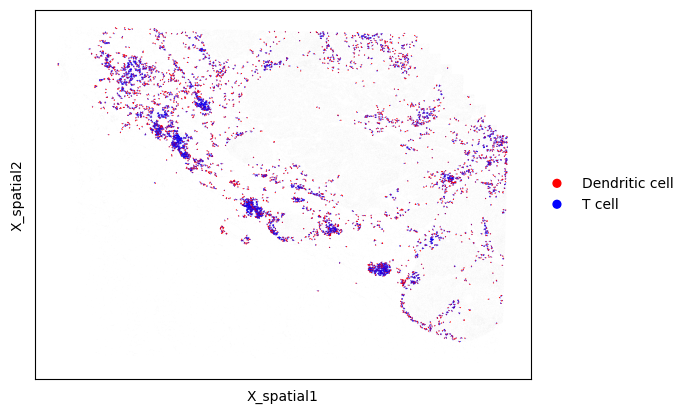

In [25]:
# Draw neighboring cells where we group the dendritic cells together
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    palette=['Red', 'Blue'],
    group1_name='Dendritic cell',
    group2_name='T cell',
    dot_size_group1=3,
    dot_size_group2=1,
)


Alternatively, we can color by each cell type that we are plotting instead of dividing the cells into the two groups 

/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/plot/_cell_neighbors.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_group1.obs[group] = adata_group1.obs[group].astype('category')
/mnt/disks/scratch/mbernstein/notebooks/2023-08-09_monkeybread_development_V2/../../monkeybread/src/monkeybread/plot/_cell_neighbors.py:188: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_group2.obs[group] = adata_group2.obs[group].astype('category')


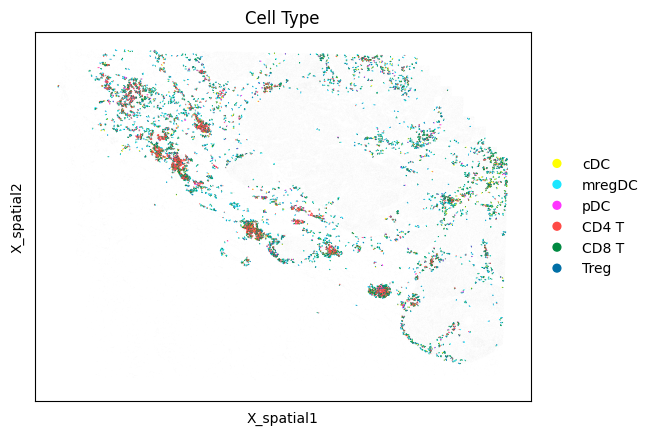

In [26]:
# Draw neighboring cells, but color by each cell's type
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    group='Cell Type',
    dot_size_group1=3,
    dot_size_group2=2,
)

### Restricting neighbors to a specific niche

Monkeybread provides a function to find neighboring cells, but restricted to each niche. The following function will output a dictionary mapping each niche to a sub-dictionary mapping each dendritic cell to its neighboring T cells

In [27]:
niche_to_cell_to_neighbors = mb.calc.cell_neighbors_per_niche(
    adata,
    niche_key='niche',
    groupby='Cell Type',
    group1=['mregDC', 'cDC', 'pDC'],
    group2=['CD4 T', 'CD8 T', 'Treg'],
    basis="X_spatial",
    radius=20,
)

We can then visualize the neighboring cells only within a specific niche. Below, we plot only neighboring cells within Niche 5

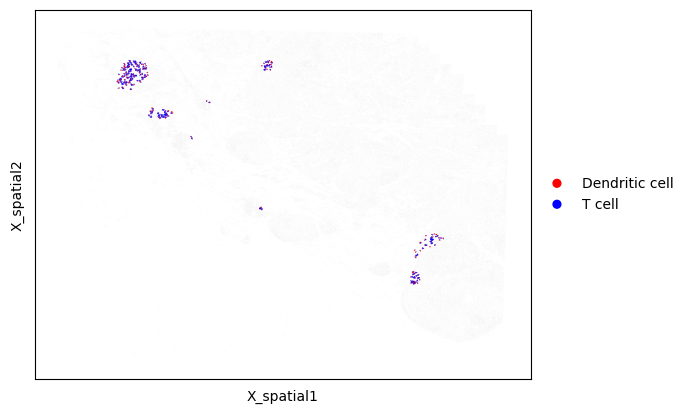

In [28]:
# Draw neighboring cells, but color by each cell's type
mb.plot.cell_neighbor_embedding(
    adata,
    niche_to_cell_to_neighbors['5'],
    palette=['Red', 'Blue'],
    group1_name='Dendritic cell',
    group2_name='T cell',
    dot_size_group1=3,
    dot_size_group2=1,
)

### Using Boolean-valued masks to define cell groups

Instead of specifying cell types by using values in a specific column of `adata.obs`, we can also select the two groups using Boolean-valued masks. Below, we generate and plot all dendritic cell/T cell neighbors, but specify the dendritic cells and T cells using two masks. This function can be used to compute neighbors between groups of cells in a more customizable way.


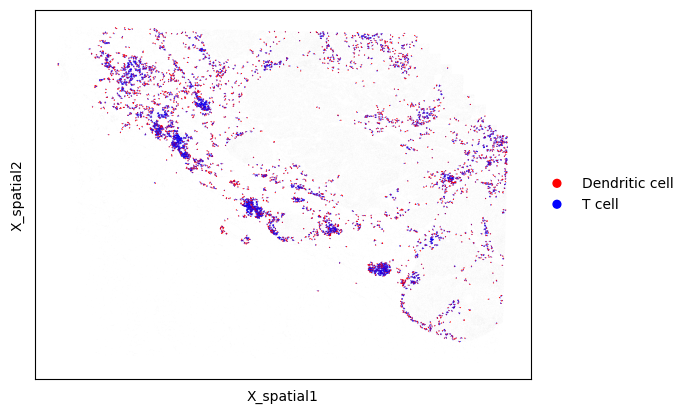

In [29]:
# Compute neighbors using masks
cell_to_neighbors = mb.calc.cell_neighbors_from_masks(
    adata,
    mask_group1=adata.obs['Cell Type'].isin(['mregDC', 'cDC', 'pDC']),   # Mask defining Group 1
    mask_group2=adata.obs['Cell Type'].isin(['CD4 T', 'CD8 T', 'Treg']), # Mask defining Group 2
    radius=20
) 

# Draw neighboring cells
mb.plot.cell_neighbor_embedding(
    adata,
    cell_to_neighbors,
    palette=['Red', 'Blue'],
    group1_name='Dendritic cell',
    group2_name='T cell',
    dot_size_group1=3,
    dot_size_group2=1,
)


Lastly, we can compute neighbors within each niche using Boolean-valued masks in a similar fashion

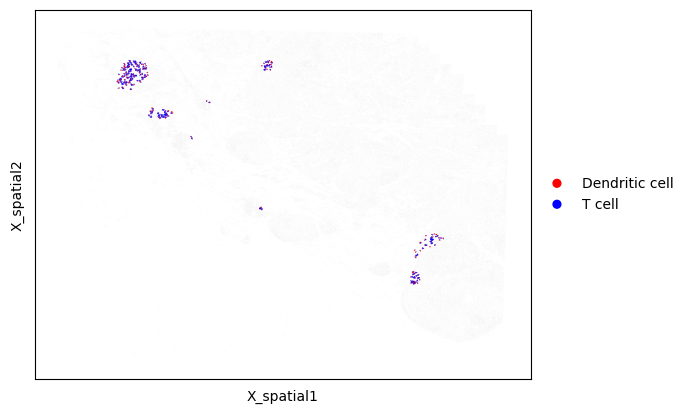

In [30]:
# Compute neighbors within each niche using masks
niche_to_cell_to_neighbors = mb.calc.cell_neighbors_per_niche_from_masks(
    adata,
    niche_key='niche',
    mask_group1=adata.obs['Cell Type'].isin(['mregDC', 'cDC', 'pDC']),   # Mask defining Group 1
    mask_group2=adata.obs['Cell Type'].isin(['CD4 T', 'CD8 T', 'Treg']), # Mask defining Group 2
    basis="X_spatial",
    radius=20,
)

# Draw neighboring cells, but color by each cell's type
mb.plot.cell_neighbor_embedding(
    adata,
    niche_to_cell_to_neighbors['5'],
    palette=['Red', 'Blue'],
    group1_name='Dendritic cell',
    group2_name='T cell',
    dot_size_group1=3,
    dot_size_group2=1,
)

## Statistical test for co-localization between a pair of cell types

Here we provide a statistical test for co-localaization betweeen cell types as an added layer of analysis into how how cells are spatially organized within tissues.

We begin by computing the shortest distance between each B cell and each CD4 Tfh cell:

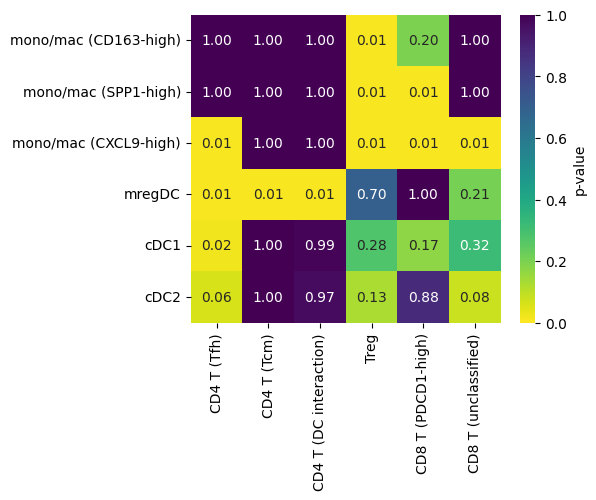

In [31]:
# Only look in niches that are not the malignant/other niche
adata_test = adata[~adata.obs['niche'].isin(['malignant/other'])]

# Define cell types we want to analyze
MOMAC_SUBTYPES = [
    'mono/mac (CD163-high)',
    'mono/mac (SPP1-high)',
    'mono/mac (CXCL9-high)',
    'mregDC',
    'cDC1',
    'cDC2'
]
T_CELL_SUBTYPES = [
    'CD4 T (Tfh)', 
    'CD4 T (Tcm)', 
    'CD4 T (DC interaction)',
    'Treg',
    'CD8 T (PDCD1-high)', 
    'CD8 T (unclassified)'
]

# Compute distance from each myeloid cell type to the nearest T cell subtype
ct1_to_ct2_to_dists = mb.calc.shortest_distances_pairwise(
    adata_test, 
    'Cell Subtype', 
    MOMAC_SUBTYPES, 
    T_CELL_SUBTYPES
)

# Calculate significance of these shortest distances
ct1_to_ct2_to_perms, ct1_to_ct2_to_pval = mb.stat.shortest_distances_pairwise(
    adata_test, 
    'Cell Subtype', 
    MOMAC_SUBTYPES, 
    T_CELL_SUBTYPES,
    n_perms=100,
    observed=ct1_to_ct2_to_dists, 
    threshold=20
)


fig, ax = mb.plot.shortest_distances_pairwise(
    ct1_to_ct2_to_pval,
    order_x=T_CELL_SUBTYPES,
    order_y=MOMAC_SUBTYPES,
    figsize=(5,4),
    show=False
);



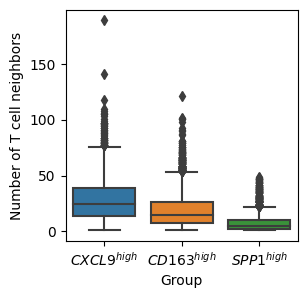

In [32]:
df_counts_m1_m2_t = mb.calc.number_of_neighbors_from_masks(
    adata,
    {
        r'$CXCL9^{high}$': adata.obs['Cell Subtype'] == 'mono/mac (CXCL9-high)',
        r'$CD163^{high}$': adata.obs['Cell Subtype'] == 'mono/mac (CD163-high)',
        r'$SPP1^{high}$': adata.obs['Cell Subtype'] == 'mono/mac (SPP1-high)'
    },
    adata.obs['Cell Type'].isin(['CD8 T', 'CD4 T', 'Treg'])
)

fig, ax = plt.subplots(1,1,figsize=(3,3))
mb.plot.number_of_neighbors(
    df_counts_m1_m2_t,
    plot='box',
    stripplot=False,
    strip_kwargs={'s': 1},
    ax=ax
)
ax.set_ylabel('Number of T cell neighbors')
plt.show()

# Ligand-receptor analysis

We will no perform a ligand receptor analysis examining how cells of various cell types are interacting in the tumor microenvironment. 

In the following example, we will examine how monocytes/macrophages are interacting with T cells in the tumor microenvironment. Specifically, it is known that CXCL10 and CXCL9 are expressed by immune cells in the presence of interferon gamma. Moreover, CXCL10 and CXCL9 bind to CXCR3. 

First, we will download all ligand-receptor pairs that include both CXCL9 and CXCL10 from the [omnipath](https://omnipathdb.org/) database:

In [33]:
lrs = mb.util.load_ligand_receptor_pairs_omnipath(adata, require_gene='CXCL9')
lrs += mb.util.load_ligand_receptor_pairs_omnipath(adata, require_gene='CXCL10')
lrs

[('CXCL9', 'FCGR2A'),
 ('CXCL9', 'CCR2'),
 ('CXCL9', 'CCR3'),
 ('CXCL9', 'CCR5'),
 ('CXCL9', 'CCR4'),
 ('CXCL9', 'CCR1'),
 ('CXCL9', 'CCR10'),
 ('CXCL9', 'CCR8'),
 ('CXCL9', 'CXCR1'),
 ('CXCL9', 'CXCR3'),
 ('CXCL9', 'CXCR6'),
 ('CXCL9', 'CCR6'),
 ('CXCL9', 'CXCR4'),
 ('CXCL9', 'CX3CR1'),
 ('CXCL9', 'CCR7'),
 ('CXCL9', 'XCR1'),
 ('CXCL9', 'CXCR5'),
 ('CXCL9', 'CXCR2'),
 ('IFNG', 'CXCL9'),
 ('IL23A', 'CXCL9'),
 ('IL12B', 'CXCL9'),
 ('TNF', 'CXCL10'),
 ('IFNG', 'CXCL10'),
 ('IL1B', 'CXCL10'),
 ('CXCL10', 'CCR2'),
 ('CXCL10', 'CCR3'),
 ('CXCL10', 'CCR5'),
 ('CXCL10', 'CCR4'),
 ('CXCL10', 'CCR1'),
 ('CXCL10', 'CCR10'),
 ('CXCL10', 'CCR8'),
 ('CXCL10', 'CXCR1'),
 ('CXCL10', 'CXCR3'),
 ('CXCL10', 'CXCR6'),
 ('CXCL10', 'CCR6'),
 ('CXCL10', 'CXCR4'),
 ('CXCL10', 'CX3CR1'),
 ('CXCL10', 'CCR7'),
 ('CXCL10', 'XCR1'),
 ('CXCL10', 'CXCR5'),
 ('CXCL10', 'CXCR2')]

Make sure all ligand-receptor pairs have either CXCL9 or CXCL10 as the first element. This is because the downstream test will test for expression of CXCL9 in the first provided cell type (which will be monocytes/macrophages) and its partner receptor will be tested for expression in the second cell type (T cells)

In [34]:
lr_pairs = []
for g1, g2 in lrs:
    if g2 in ['CXCL9', 'CXCL10']:
        lr_pairs.append((g2, g1))
    else:
        lr_pairs.append((g1, g2))
lr_pairs

[('CXCL9', 'FCGR2A'),
 ('CXCL9', 'CCR2'),
 ('CXCL9', 'CCR3'),
 ('CXCL9', 'CCR5'),
 ('CXCL9', 'CCR4'),
 ('CXCL9', 'CCR1'),
 ('CXCL9', 'CCR10'),
 ('CXCL9', 'CCR8'),
 ('CXCL9', 'CXCR1'),
 ('CXCL9', 'CXCR3'),
 ('CXCL9', 'CXCR6'),
 ('CXCL9', 'CCR6'),
 ('CXCL9', 'CXCR4'),
 ('CXCL9', 'CX3CR1'),
 ('CXCL9', 'CCR7'),
 ('CXCL9', 'XCR1'),
 ('CXCL9', 'CXCR5'),
 ('CXCL9', 'CXCR2'),
 ('CXCL9', 'IFNG'),
 ('CXCL9', 'IL23A'),
 ('CXCL9', 'IL12B'),
 ('CXCL10', 'TNF'),
 ('CXCL10', 'IFNG'),
 ('CXCL10', 'IL1B'),
 ('CXCL10', 'CCR2'),
 ('CXCL10', 'CCR3'),
 ('CXCL10', 'CCR5'),
 ('CXCL10', 'CCR4'),
 ('CXCL10', 'CCR1'),
 ('CXCL10', 'CCR10'),
 ('CXCL10', 'CCR8'),
 ('CXCL10', 'CXCR1'),
 ('CXCL10', 'CXCR3'),
 ('CXCL10', 'CXCR6'),
 ('CXCL10', 'CCR6'),
 ('CXCL10', 'CXCR4'),
 ('CXCL10', 'CX3CR1'),
 ('CXCL10', 'CCR7'),
 ('CXCL10', 'XCR1'),
 ('CXCL10', 'CXCR5'),
 ('CXCL10', 'CXCR2')]

Here, we calculate the co-expression score of ligand-receptor pairs that include CXCL9 or CXCL10 between monocytes/macrophages and T cells. This score is defined as `sqrt(l*r)` where `l` is the expression of the ligand and `r` is the expression of the receptor. 

In [35]:
# For each pDC, find the neighboring Tregs
cell_to_neighbors = mb.calc.cell_neighbors(
    adata,
    groupby='Cell Type',
    group1=['mono/mac'],
    group2=['CD8 T', 'CD4 T', 'Treg'],
    radius=20
) 

lr_pair_to_score = mb.calc.ligand_receptor_score(
    adata,
    cell_to_neighbors,
    lr_pairs=lr_pairs
)
lr_pair_to_score

{('CXCL9', 'FCGR2A'): 0.07040571149562302,
 ('CXCL9', 'CCR2'): 0.08018515664115061,
 ('CXCL9', 'CCR3'): 0.014533251476410197,
 ('CXCL9', 'CCR5'): 0.1761661972044466,
 ('CXCL9', 'CCR4'): 0.20678095944843852,
 ('CXCL9', 'CCR1'): 0.11133095167432018,
 ('CXCL9', 'CCR10'): 0.042914027113093375,
 ('CXCL9', 'CCR8'): 0.06402798936241473,
 ('CXCL9', 'CXCR1'): 0.008926698620411804,
 ('CXCL9', 'CXCR3'): 0.2840142124573646,
 ('CXCL9', 'CXCR6'): 0.16032792844681917,
 ('CXCL9', 'CCR6'): 0.015280171516791606,
 ('CXCL9', 'CXCR4'): 0.49782086328895075,
 ('CXCL9', 'CX3CR1'): 0.033904315943592174,
 ('CXCL9', 'CCR7'): 0.3420557372504459,
 ('CXCL9', 'XCR1'): 0.0315906868323548,
 ('CXCL9', 'CXCR5'): 0.0711695629331993,
 ('CXCL9', 'CXCR2'): 0.009412246781930603,
 ('CXCL9', 'IFNG'): 0.05271924847255687,
 ('CXCL9', 'IL23A'): 0.11774595916974372,
 ('CXCL9', 'IL12B'): 0.01459330971109616,
 ('CXCL10', 'TNF'): 0.05074289126550912,
 ('CXCL10', 'IFNG'): 0.037815382749426966,
 ('CXCL10', 'IL1B'): 0.019400741682671245

Next we will use these co-expression scores to calculate a p-value for enrichment of co-expression of CXCL10/CXCR3 and CXCL9/CXCR3
between each monocyte/macrophgae and their neighboring T cells.

This statistical test is described in detail in [He _et al_., _bioRxiv_, 2022](https://doi.org/10.1101/2021.11.03.467020) (See Figure 4). 

In [54]:
res = mb.stat.ligand_receptor_score(
    adata,
    cell_to_neighbors,
    actual_scores=lr_pair_to_score
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.66s/it]


To summarize the results, we can plot the p-value vs. the score itself. To do so, we call `ligand_receptor_scatter` and pass the observed scores, `lr_pair_to_score`, and the results from the permutation test stored in `res`. 

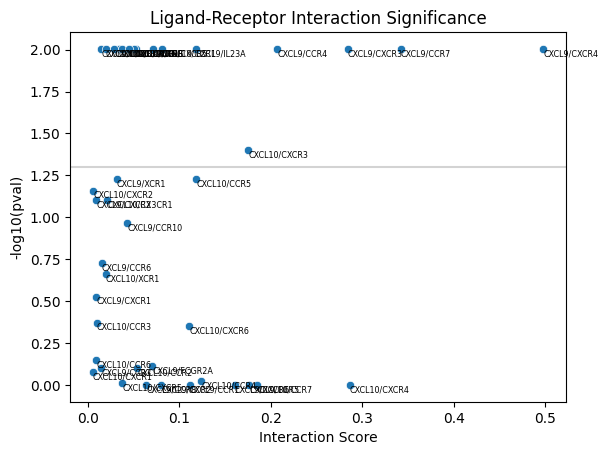

In [55]:
mb.plot.ligand_receptor_scatter(
    lr_pair_to_score,
    res
)

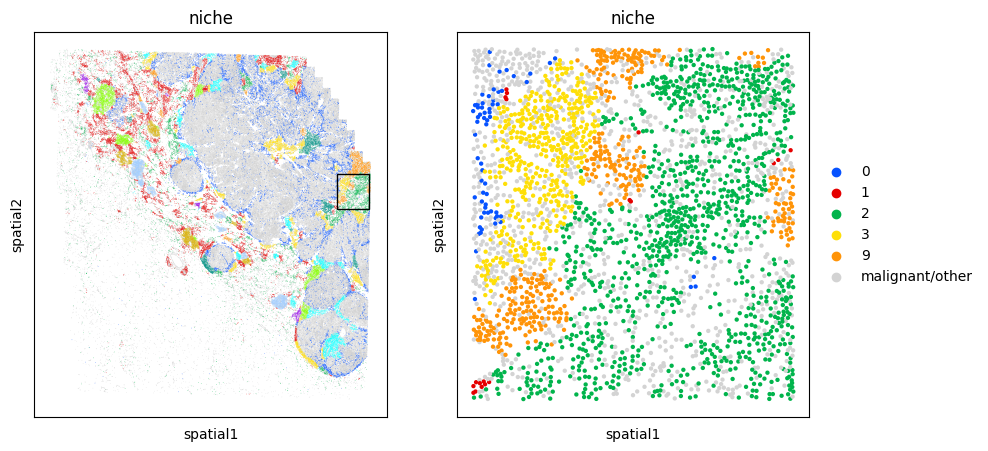

/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


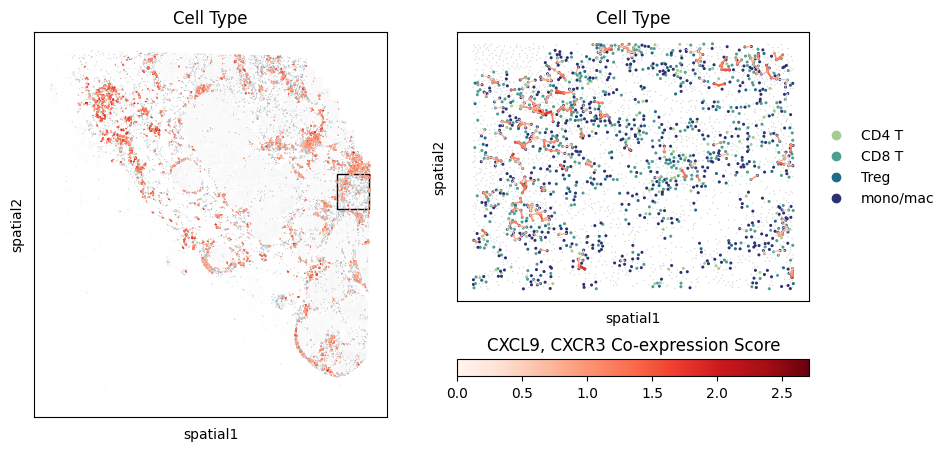

In [37]:
LEFT_PCT = 86
TOP_PCT = 37
WIDTH_PCT = 9
HEIGHT_PCT = 9

# Plot the niche
fig, axarr = plt.subplots(1,2,figsize=(10,5))
mb.plot.embedding_zoom(
    adata, 
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT, 
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    color='niche', 
    basis='spatial', 
    show=True,
    axs=axarr
)

# Plot the cells co-expressing CXCL9/CXCR3
fig, axarr = plt.subplots(1,2,figsize=(10,5))
lr_scores = mb.plot.ligand_receptor_embedding_zoom(
    adata,
    ('CXCL9', 'CXCR3'),
    cell_to_neighbors,
    color='Cell Type',
    palette='crest',
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT,
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    cmap_name='Reds',
    max_lw=3,
    max_lw_scale_unzoom=0.5,
    vmin=-1,
    vmax=1,
    axs=axarr
)

/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/mnt/disks/scratch/mbernstein/miniconda3/python3/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


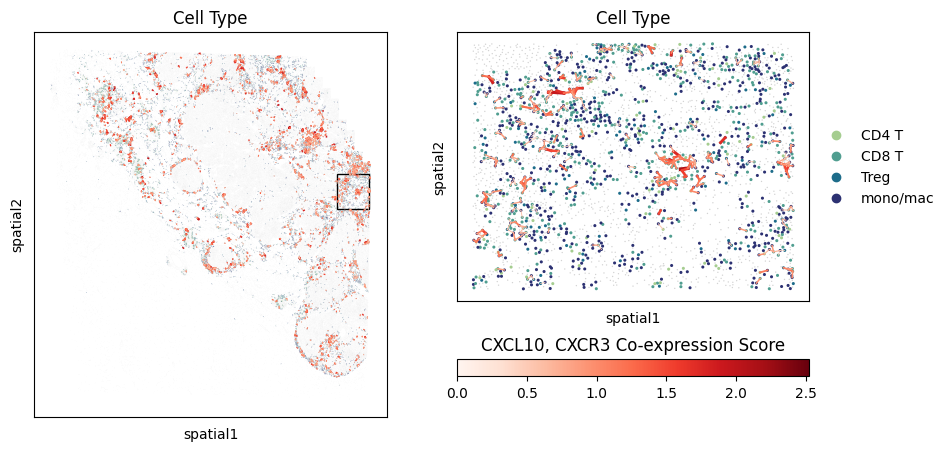

In [38]:

fig, axarr = plt.subplots(1,2,figsize=(10,5))
mb.plot.ligand_receptor_embedding_zoom(
    adata,
    ('CXCL10', 'CXCR3'),
    cell_to_neighbors,
    color='Cell Type',
    palette='crest',
    left_pct=LEFT_PCT,
    top_pct=TOP_PCT,
    width_pct=WIDTH_PCT,
    height_pct=HEIGHT_PCT,
    cmap_name='Reds',
    max_lw=3,
    max_lw_scale_unzoom=0.5,
    vmin=-1,
    vmax=1,
    axs=axarr
)
plt.show()

### Examine ligand-receptor co-expression within each niche

Monkeybread also enables one to compute the ligand/receptor co-expression score separate in each niche using the `ligand_receptor_score_per_niche` as shown below. This function will output a dictionary mapping each niche to a sub-dictionary mapping each ligand/receptor (as a tuple) to its score in that niche

In [39]:
# Compute neighbors within each niche using masks
niche_to_cell_to_neighbors = mb.calc.cell_neighbors_per_niche_from_masks(
    adata,
    niche_key='niche',
    mask_group1=adata.obs['Cell Type'].isin(['mregDC', 'cDC', 'pDC']),   # Mask defining Group 1
    mask_group2=adata.obs['Cell Type'].isin(['CD4 T', 'CD8 T', 'Treg']), # Mask defining Group 2
    basis="X_spatial",
    radius=20,
)


niche_to_lr_to_score = mb.calc.ligand_receptor_score_per_niche(
    adata,
    niche_to_cell_to_neighbors,
    lr_pairs=[['CD80', 'CD28'], ['CXCL9', 'CXCR3'], ['CXCL10', 'CXCR3']],
)
niche_to_lr_to_score

{'0': {('CD80', 'CD28'): 0.038968787423613246,
  ('CXCL9', 'CXCR3'): 0.26205640871324354,
  ('CXCL10', 'CXCR3'): 0.1639530680047378},
 '1': {('CD80', 'CD28'): 0.042547446950354444,
  ('CXCL9', 'CXCR3'): 0.2596883374374236,
  ('CXCL10', 'CXCR3'): 0.11111535095942564},
 '10': {('CD80', 'CD28'): 0.11275302869383641,
  ('CXCL9', 'CXCR3'): 0.17659622403333813,
  ('CXCL10', 'CXCR3'): 0.04144585956626224},
 '2': {('CD80', 'CD28'): 0.027106661233842744,
  ('CXCL9', 'CXCR3'): 0.12756280129000266,
  ('CXCL10', 'CXCR3'): 0.11371357840780887},
 '3': {('CD80', 'CD28'): 0.03270392596853227,
  ('CXCL9', 'CXCR3'): 0.2373113063786993,
  ('CXCL10', 'CXCR3'): 0.1174176786645885},
 '4': {('CD80', 'CD28'): 0.10167869541287837,
  ('CXCL9', 'CXCR3'): 0.38785683236471036,
  ('CXCL10', 'CXCR3'): 0.13361152622342526},
 '5': {('CD80', 'CD28'): 0.07019703580079344,
  ('CXCL9', 'CXCR3'): 0.3276252960757174,
  ('CXCL10', 'CXCR3'): 0.10750502254988206},
 '6': {('CD80', 'CD28'): 0.07294524320259621,
  ('CXCL9', 'CXCR

These per niche scores can then be plotted as follows:

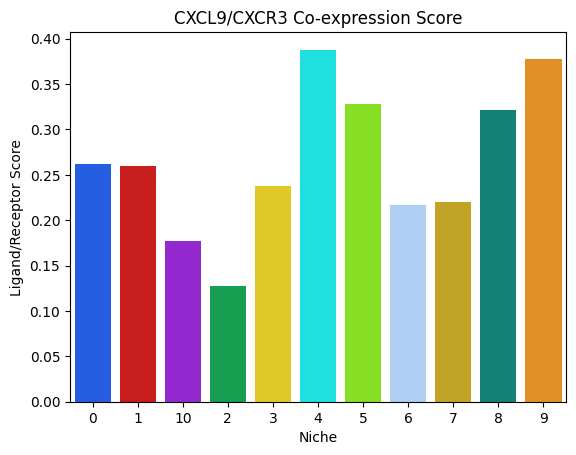

In [42]:
niches = [x for x in niche_to_lr_to_score if x != 'malignant/other'] # Don't plot the malignant/other niche

# Function to plot niche-specific ligand-receptor scores
mb.plot.ligand_receptor_score_barplot_per_niche(
    niche_to_lr_to_score, 
    ('CXCL9', 'CXCR3'),
    plot_niches=niches,
    palette=[
        niche_to_color[x] for x in sorted(niches)
    ]
)

Lastly, we can plot the ligand-receptor co-expression score for multiple ligand receptors using a heatmap. By setting `z_score=True`, we plot the z-score normalized scores, where the z-score is computed for each ligand/receptor pair over the niches. The parameter `clip_z=2` clips the maximum and minimum z-scores to 2 and -2 (i.e., 2 and -2 standard deviations from the mean).

Text(663.7777777777777, 0.5, 'Ligand/Receptor')

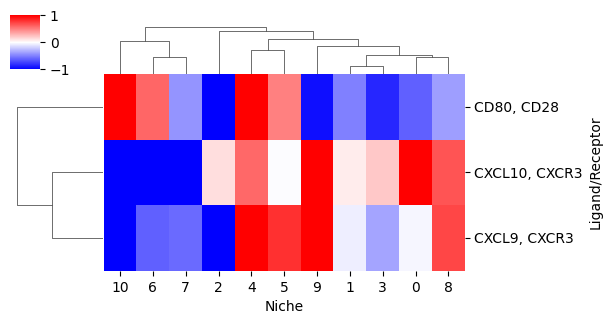

In [53]:
cg = mb.plot.ligand_receptor_score_heatmap_per_niche(
    niche_to_lr_to_score,
    plot_niches=niches,
    z_score=True, 
    clip_z=1, 
    cmap='bwr',
    figsize=(6,3),
    show=False
)
cg.ax_heatmap.set_xlabel('Niche')
cg.ax_heatmap.set_ylabel('Ligand/Receptor')